In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from xgboost import XGBClassifier, plot_importance

Preprocessing
* No null values
* No encoding needed

In [ ]:
# Load data
kidney_df = pd.read_csv("kidney_disease_dataset.csv")
# Drop 'Dialysis_Needed' variable -- not used for this classification analysis
kidney_df = kidney_df.drop('Dialysis_Needed', axis=1)

In [ ]:
kidney_df.head()

,Age,Creatinine_Level,BUN,Diabetes,Hypertension,GFR,Urine_Output,CKD_Status
0,71,0.30,40.9,0,1,46.8,1622.0,1
1,34,1.79,17.1,0,0,43.8,1428.0,1
2,80,2.67,15.0,0,1,78.2,1015.0,1
3,40,0.97,31.1,0,1,92.8,1276.0,1
4,43,2.05,22.8,1,1,62.2,1154.0,0


In [ ]:
# Start w/ basic EDA to give an overview of the data
print(kidney_df.info())
print(kidney_df.describe())
print(kidney_df['CKD_Status'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               2304 non-null   int64  
 1   Creatinine_Level  2304 non-null   float64
 2   BUN               2304 non-null   float64
 3   Diabetes          2304 non-null   int64  
 4   Hypertension      2304 non-null   int64  
 5   GFR               2304 non-null   float64
 6   Urine_Output      2304 non-null   float64
 7   CKD_Status        2304 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 144.1 KB
None
               Age  Creatinine_Level          BUN     Diabetes  Hypertension  \
count  2304.000000       2304.000000  2304.000000  2304.000000   2304.000000   
mean     54.159288          1.305638    18.813672     0.406684      0.498264   
std      20.513729          0.789594    10.508358     0.491322      0.500106   
min      20.000000          0.300000     5.0000

Train-test split
* Traditional 80/20 split
* Stratified K-fold to balance small sample size

In [ ]:
# Define features
X = kidney_df.drop('CKD_Status', axis=1)
y = kidney_df['CKD_Status']

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Scaling (for LR only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Models
* Logistic Regression (scaling)
* Random Forests (not scaled)

In [ ]:
# Logisitc Regresion model (LR)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Random Forest model (RF)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Model Evaluation

In [ ]:
# Logistic Regression
y_pred_lr = lr.predict(X_test_scaled)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1]))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       226
           1       0.85      0.83      0.84       235

    accuracy                           0.84       461
   macro avg       0.84      0.84      0.84       461
weighted avg       0.84      0.84      0.84       461

ROC AUC: 0.9091696479005837


In [ ]:
# Random Forest
y_pred_rf = rf.predict(X_test)
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       226
           1       1.00      1.00      1.00       235

    accuracy                           1.00       461
   macro avg       1.00      1.00      1.00       461
weighted avg       1.00      1.00      1.00       461

ROC AUC: 0.9999999999999999


SANITY CHECK - why does RF result in 100% accuracy?


In [ ]:
# Create function to test accuracy of both LR and RF
def test_models(X_subset, y): # restate test/train split
    X_train, X_test, y_train, y_test = train_test_split(
        X_subset, y, test_size=0.2, random_state=42, stratify=y
    )

    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    lr_acc = lr.score(X_test, y_test) # no scaling (see if separation is linear)

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    rf_acc = rf.score(X_test, y_test)

    return rf_acc, lr_acc

In [ ]:
# Run correlation for each variable with CKD_Status
correlations_ckd = kidney_df.corr(numeric_only=True)['CKD_Status'].abs().sort_values(ascending=False)
print(f"Feature correlations with CKD_Status \n {correlations_ckd}")

Feature correlations with CKD_Status 
 CKD_Status          1.000000
GFR                 0.601672
BUN                 0.305803
Creatinine_Level    0.185017
Urine_Output        0.041600
Hypertension        0.027722
Diabetes            0.018322
Age                 0.012416
Name: CKD_Status, dtype: float64


In [ ]:
# Determine how dropping features changes accuracy
features_sorted = correlations_ckd.index[1:]  # skip CKD_Status of course
X_current = X.copy() # make copy -- ensure cleanliness!

for variable in range(len(features_sorted)):
    rf_acc, lr_acc = test_models(X_current, y)
    print(f"Dropping top {variable} features: RF = {rf_acc:.4f}, LR = {lr_acc:.4f}")

    # Drop the next most correlated feature
    if variable < len(features_sorted):
        X_current = X_current.drop(columns=[features_sorted[variable]])

Dropping top 0 features: RF = 1.0000, LR = 0.8330
Dropping top 1 features: RF = 0.6963, LR = 0.6247
Dropping top 2 features: RF = 0.5597, LR = 0.5271
Dropping top 3 features: RF = 0.4967, LR = 0.4902
Dropping top 4 features: RF = 0.5228, LR = 0.5033
Dropping top 5 features: RF = 0.5336, LR = 0.5054
Dropping top 6 features: RF = 0.5076, LR = 0.5119


RF accuracy drops to 0.6963 from 1.0 by dropping GFR. Retrain both models without GFR.

In [ ]:
# Define NEW features
kidney_df_new = kidney_df.drop('GFR', axis=1)

X_new = kidney_df_new.drop('CKD_Status', axis=1)
y_new = kidney_df_new['CKD_Status']

In [ ]:
# NEW Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y_new, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# NEW Scaling (for LR only)
scaler = StandardScaler()
X_train_scaled_new = scaler.fit_transform(X_train)
X_test_scaled_new = scaler.transform(X_test)

In [ ]:
# NEW Logisitc Regresion model (LR)
lr_new = LogisticRegression(max_iter=1000)
lr_new.fit(X_train_scaled_new, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# NEW Random Forest model (RF)
rf_new = RandomForestClassifier(n_estimators=100, random_state=42)
rf_new.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# NEW Logistic Regression predictions
y_pred_lr_new = lr_new.predict(X_test_scaled_new)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr_new))
print("ROC AUC:", roc_auc_score(y_test, lr_new.predict_proba(X_test_scaled_new)[:, 1]))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       226
           1       0.63      0.62      0.63       235

    accuracy                           0.62       461
   macro avg       0.62      0.62      0.62       461
weighted avg       0.62      0.62      0.62       461

ROC AUC: 0.6785539446431933


In [ ]:
# NEW Random Forest predictions
y_pred_rf_new = rf_new.predict(X_test)
print("Random Forest:")
print(classification_report(y_test, y_pred_rf_new))
print("ROC AUC:", roc_auc_score(y_test, rf_new.predict_proba(X_test)[:, 1]))

Random Forest:
              precision    recall  f1-score   support

           0       0.65      0.82      0.73       226
           1       0.77      0.57      0.66       235

    accuracy                           0.70       461
   macro avg       0.71      0.70      0.69       461
weighted avg       0.71      0.70      0.69       461

ROC AUC: 0.7506495951798156


Visualizations:
* Confusion Matrix for each model
* ROC Curve
* Feature Importance (RF)
* Coefficients (LR)

In [ ]:
# Custom colors to match slides for presentation!
colors_red = ['#f9f9fa', '#f4e3d4', '#f3a2a2', '#f06e6e']
custom_cmap_red = LinearSegmentedColormap.from_list("custom_cmap_red", colors_red)
colors_blue = ['#f9f9fa', '#bec3c9', '#b4dbff', '#062036']
custom_cmap_blue = LinearSegmentedColormap.from_list("custom_cmap_blue", colors_blue)

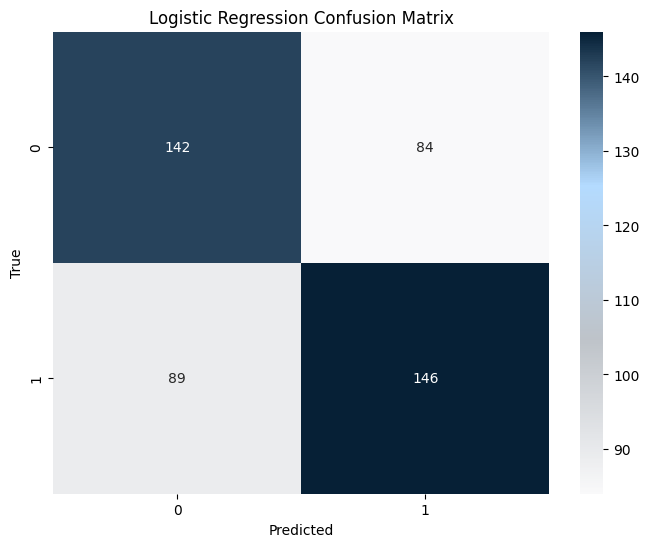

In [ ]:
# Confusion Matrix for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_lr_new), annot=True, fmt='d', cmap=custom_cmap_blue)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("viz/confusion_lr.png")
plt.show()

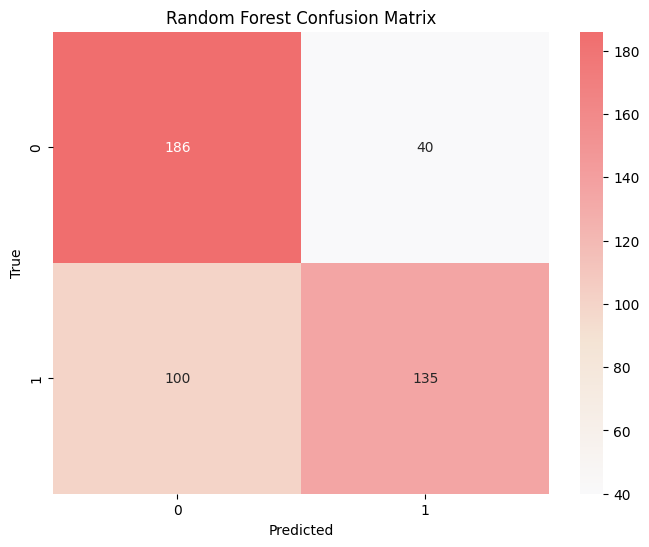

In [ ]:
# Confusion Matrix for Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf_new), annot=True, fmt='d', cmap=custom_cmap_red)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("viz/confusion_rf.png")
plt.show()

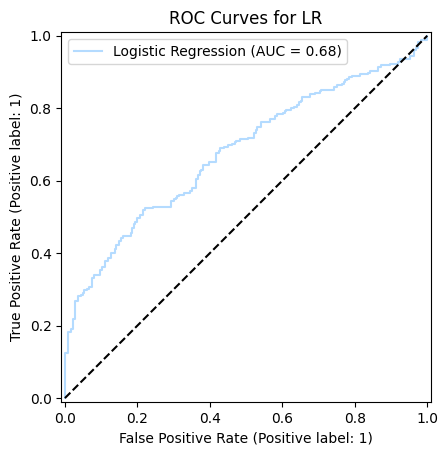

In [ ]:
# ROC Curve for LR
RocCurveDisplay.from_estimator(lr_new, X_test_scaled_new, y_test, name='Logistic Regression', color='#b4dbff')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves for LR")
plt.legend()
plt.savefig("viz/ROC_lr.png")
plt.show()

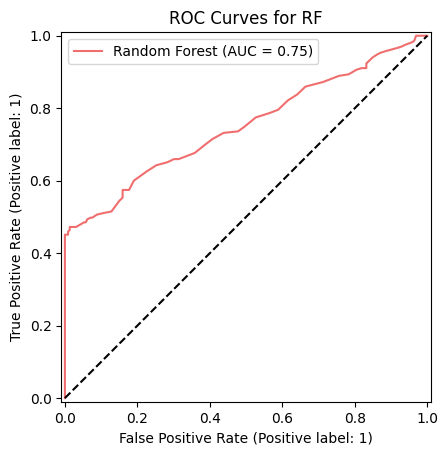

In [ ]:
# ROC Curves for RF
RocCurveDisplay.from_estimator(rf_new, X_test, y_test, name='Random Forest', color='#f06e6e')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves for RF")
plt.legend()
plt.savefig("viz/ROC_rf.png")
plt.show()

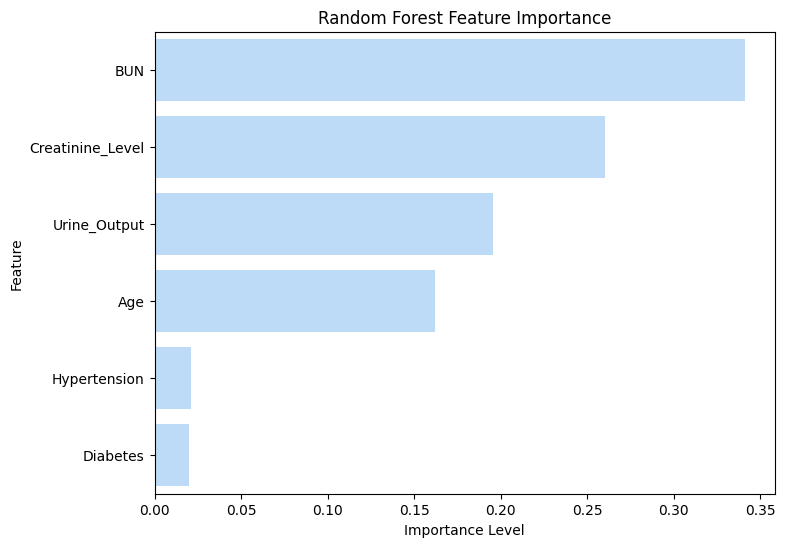

In [ ]:
# Feature Importance of the Random Forest model - which features are most influential?
importances = rf_new.feature_importances_
features = X_new.columns
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance, y=feature_importance.index, color='#b4dbff')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Level")
plt.ylabel("Feature")
plt.savefig("viz/feat_imp_rf.png")
plt.show()

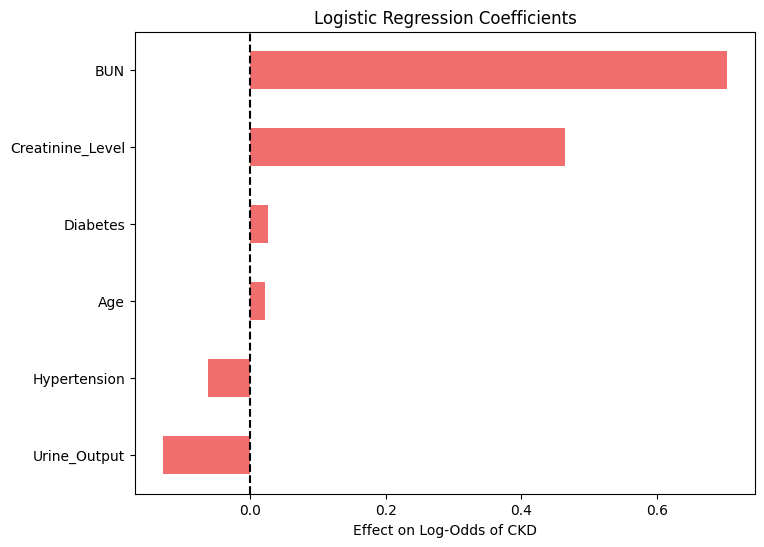

In [ ]:
# Coefficient Plot of the Logistic Regression model - in which direction do the features influence?
coefs = pd.Series(lr_new.coef_[0], index=X_new.columns).sort_values()

plt.figure(figsize=(8, 6))
coefs.plot(kind="barh", color='#f06e6e')
plt.title("Logistic Regression Coefficients")
plt.xlabel("Effect on Log-Odds of CKD")
plt.axvline(0, color='black', linestyle='--')
plt.savefig("viz/coeff_lr.png")
plt.show()

Testing model classifications

In [ ]:
# Probabilities of positive class (CKD = 1)
prob_rf = rf_new.predict_proba(X_test)[:, 1]
prob_lr = lr_new.predict_proba(X_test_scaled_new)[:, 1]

In [ ]:
# Probability threshold (to define "high risk")
threshold = 0.7 # experiment with different thresholds
high_risk = prob_rf >= threshold # mess w/ lr to see if probability changes

In [ ]:
# Add risk labels to patients ("high" vs "low/moderate")
risk_labels = np.where(high_risk, "High Risk", "Low/Moderate Risk")
results_df = X_test.copy()
results_df["CKD_Prob"] = prob_rf
results_df["Risk_Label"] = risk_labels

In [ ]:
results_df.head()

,Age,Creatinine_Level,BUN,Diabetes,Hypertension,Urine_Output,CKD_Prob,Risk_Label
749,70,1.23,17.3,0,0,1103.0,0.49,Low/Moderate Risk
768,83,1.30,22.6,0,1,1256.0,0.32,Low/Moderate Risk
95,56,0.30,33.9,1,0,1699.0,1.00,High Risk
1618,84,0.30,25.2,1,0,737.0,0.43,Low/Moderate Risk
1968,24,1.83,7.3,1,0,1394.0,0.16,Low/Moderate Risk


In [ ]:
risk_counts = results_df['Risk_Label'].value_counts()
print(risk_counts)
print(f"Total number of patients in testing set: {len(results_df)}")

Risk_Label
Low/Moderate Risk    349
High Risk            112
Name: count, dtype: int64
Total number of patients in testing set: 461


Try XGBoost to improve model accuracy

In [ ]:
# XGBoost model
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_acc:.4f}")

XGBoost Accuracy: 0.6811


In [ ]:
# Tune XGBoost with different parameters to improve accuracy
xgb_tune = XGBClassifier(
    n_estimators=200, # increases tree size (default is 100)
    learning_rate=0.05, # decrease step size
    max_depth=4, # limit tree depth (avoid overfitting)
    subsample=0.8, # only uses 80% of data per tree (avoid overfitting)
    colsample_bytree=0.8, # only uses 80% of features per tree (avoid overfitting)
    random_state=42
    )

In [ ]:
# Include cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_tune, X_train, y_train, cv=cv, scoring='accuracy')
print(f"XGBoost Cross Validation Accuracy: {np.mean(cv_scores):.4f}")

XGBoost Cross Validation Accuracy: 0.7021


In [ ]:
# Train on training set
xgb_tune.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Predictions on XGBoost
y_pred_xgb = xgb_tune.predict(X_test)
xgb_acc = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy (test set): {xgb_acc:.4f}")

XGBoost Accuracy (test set): 0.7093


XGBoost does not give further insight or improve model accuracy.